In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import DBSCAN
#from model import SimCLRModel
#from mlp import MLP
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else (torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu'))

In [2]:
anomaly_idx = 7 # WhiteBursts for now
def mask(labels, anomaly_idx, remove_anomaly=True):
    if remove_anomaly:
        return (labels == anomaly_idx)
    else:
        return (labels != anomaly_idx)

In [3]:
class GwakDataset(Dataset):
    def __init__(self, 
                 path='/n/holystore01/LABS/iaifi_lab/Lab/phlab-neurips25/GWAK/', 
                 anomaly_index = 7, remove_anomaly=True, normalize=False):
        data = self.fill_data(path+'/O3a_dataset.npz', normalize=normalize)
        glitches = self.fill_data(path+'/glitches.npz', normalize=normalize, label=9)
        data_full = np.concatenate([data[0], glitches[0]], axis=0)
        labels_full = np.concatenate([data[1], glitches[1]], axis=0)
        idx_mask = mask(labels_full, anomaly_idx, remove_anomaly).flatten()
        self.data = np.delete(data_full, idx_mask, axis=0)
        self.labels = np.delete(labels_full, idx_mask, axis=0)

    def fill_data(self, path, normalize=True, label=None):
        file = np.load(path)
        if path.endswith('npz'):
            data = file['data']
        else:
            data = file
        if normalize:
            stds = np.std(data, axis=-1)[:, :, np.newaxis]
            data = data/stds
        #data = np.swapaxes(data, 1, 2)
        data = np.float32(data)
        if 'label' in file.keys():
            target = file['label']
        else:
            target = np.full(data.shape[0], label)
        return data, target
    
    def generate_augmentation(self,batch):
        return None
    
    def normalize(self,batch):
        return (batch - self.mean.to(batch)) / self.std.to(batch)

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self,idx):
        return self.data[idx, :, :], self.labels[idx]

In [4]:
str_label = [
    "SineGaussian",
    "BBH",
    "Gaussian",
    "Cusp",
    "Kink",
    "KinkKink",
    "WhiteNoiseBurst",
    "Background",
    "Glitches"
]
int_label = [1,2,3,4,5,6,7,8,9] #remove 7 since WhiteBurst is treated as anomaly

# remove anomalies from list
str_label.pop(anomaly_idx-1)
int_label.pop(anomaly_idx-1)

7

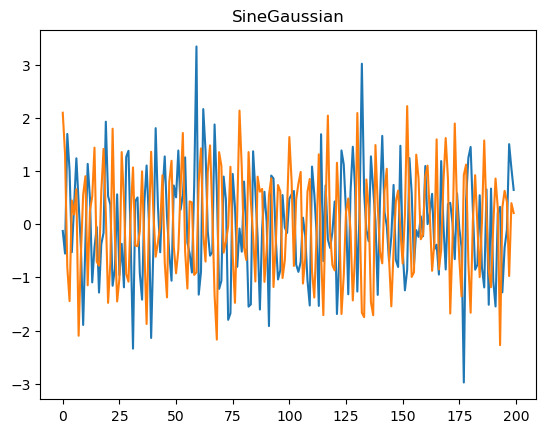

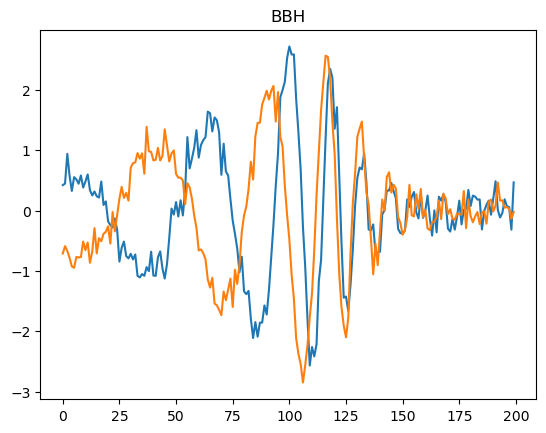

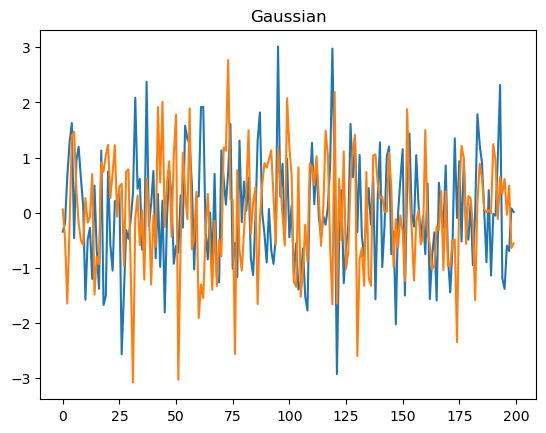

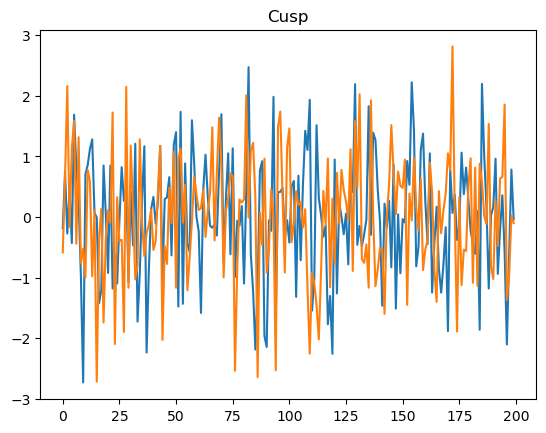

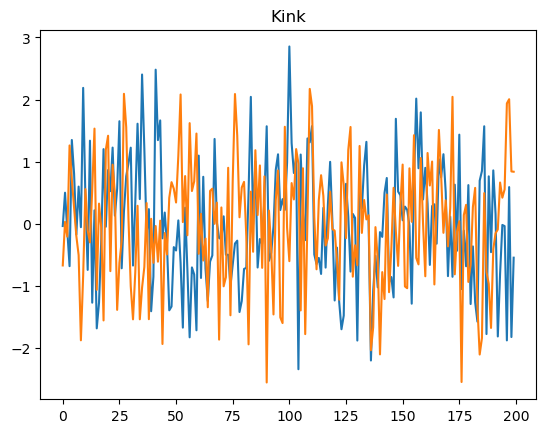

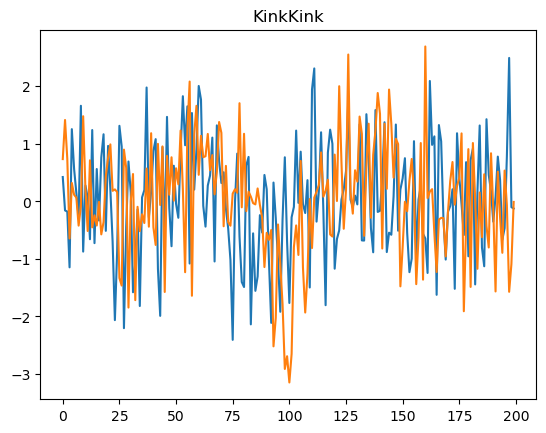

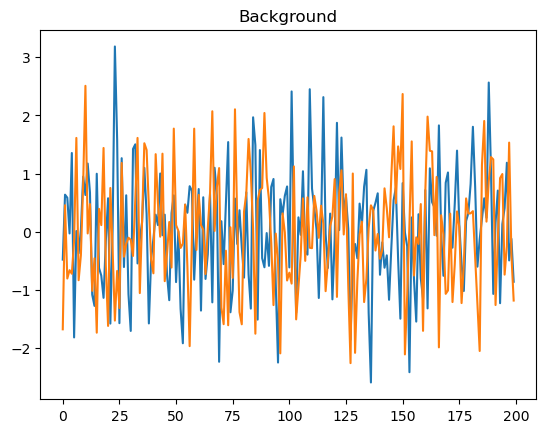

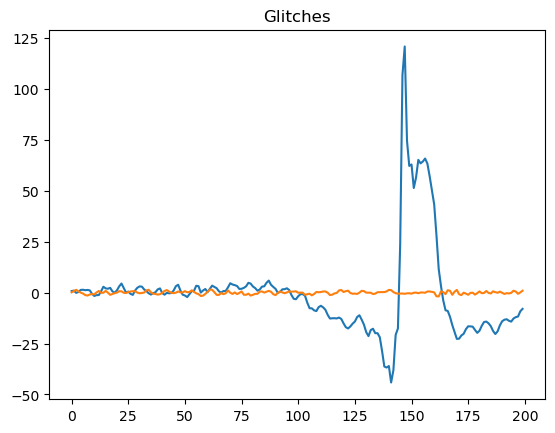

In [5]:
dset = GwakDataset()
generator = torch.Generator().manual_seed(42)
trainset, testset = torch.utils.data.random_split(dset, [0.8,0.2], generator=generator)

data = dset.data
labels = dset.labels

# plot time series for each dataset
for idx, i in enumerate(int_label):
    text = str_label[idx]
    selc = data[labels==i][0]
    times = np.arange(selc.shape[1])
    fig = plt.figure()

    plt.plot(times, selc[0,:])
    plt.plot(times, selc[1,:])
    plt.title(text)
    fig.show()

In [6]:
import sys
sys.path.append('../../')

from models.losses import SupervisedSimCLRLoss
from models.networks import MLP
from models.litmodels import SimCLRModel
from models.resnet_1d import ResNet1D
from tqdm import tqdm

# Training loop
num_epochs = 100
batch_size = 350
# Dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Model specifications
temp = 0.05
criterion = SupervisedSimCLRLoss(temperature=temp)
# Define a dummy CNN model
embed_dim = 4
embedder = ResNet1D(in_channels=2, layers=[3, 4, 6, 3], classes=embed_dim).to(device)
projector = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim).to(device)
model = SimCLRModel(embedder, projector).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

#losses = []
#for epoch in tqdm(range(num_epochs)):
#    model.train()
#    epoch_loss = []
#    for batch_data, labels in trainloader:
#        batch_data = batch_data.float().to(device)
#
#        # Potential to add any augmentation here
#        features = model(batch_data).unsqueeze(1)
#        
#        # Compute SimCLR loss
#        loss = criterion(features,labels=labels)
#        
#        # Backward pass and optimization
#        optimizer.zero_grad()
#        loss.backward()
#        optimizer.step()
#        
#        epoch_loss.append(loss.item())
#    mean_loss = np.mean(epoch_loss)
#    losses.append(mean_loss)
#    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {mean_loss:.4f}')    

#torch.save(model.state_dict(), '/n/holystore01/LABS/iaifi_lab/Lab/phlab-neurips25/GWAK/model_4dim_O3a.pth')
#plt.figure(figsize=(8,6))
#plt.plot(np.arange(len(losses)),losses)

/n/holylabs/LABS/iaifi_lab/Users/creissel/miniforge3/envs/ssm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/n/holylabs/LABS/iaifi_lab/Users/creissel/miniforge3/envs/ssm/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(
/n/holylabs/LABS/iaifi_lab/Users/creissel/miniforge3/envs/ssm/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.
  rank_zero_warn(


In [10]:
def evaluation(dset, model):
    data = torch.from_numpy(testset[:][0])
    labels = testset[:][1]
    with torch.no_grad():
        output = []
        for sp in torch.split(data,10000):
            #sp = testset.normalize(sp)
            output.append(model(sp.to(device),embed=True).cpu().numpy())
    output = np.concatenate(output,axis=0)
    return labels, output

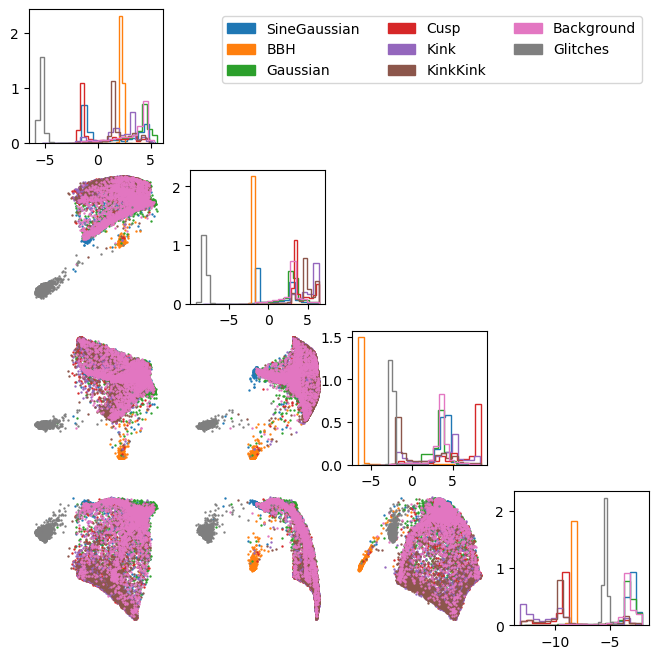

In [30]:
data_label, data_embedding = evaluation(testset, model)
from utils.plotting import make_corner
make_corner(data_embedding, data_label, {1:"SineGaussian", 2:"BBH", 3:"Gaussian", 4:"Cusp", 5:"Kink", 6:"KinkKink", 8:"Background", 9:"Glitches"})
np.savez('/n/holystore01/LABS/iaifi_lab/Lab/phlab-neurips25/GWAK/embedding/data.npz', data=data_embedding, label=data_label)

In [31]:
ref_label, ref_embedding = evaluation(trainset, model)
np.savez('/n/holystore01/LABS/iaifi_lab/Lab/phlab-neurips25/GWAK/embedding/reference.npz', data=ref_embedding, label=ref_label)

In [32]:
anomaly = GwakDataset(remove_anomaly=False)
anomaly_label, anomaly_embedding = evaluation(anomaly, model)
np.savez('/n/holystore01/LABS/iaifi_lab/Lab/phlab-neurips25/GWAK/embedding/anomaly.npz', data=anomaly_embedding, label=anomaly_label)